**Import Libraries**

In [17]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
random.seed(42)
np.random.seed(42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Connect Drive Link**

In [18]:
data = '/content/drive/MyDrive/CVPR/animal_dataset'
classes = ["cat", "dog", "panda"]
all_paths = [os.path.join(data, cls) for cls in classes]
image_files = []
image_size = (32, 32)

**Class Names and Count Images**

In [19]:
class_names = sorted(os.listdir(data))
print("Classes found:", class_names)
img_count = {}
for cname in class_names:
    folder = os.path.join(data, cname)
    img_count[cname] = len(os.listdir(folder))
print("\nImages per class:", img_count)
print("Total images:", sum(img_count.values()))

Classes found: ['cat', 'dog', 'panda']

Images per class: {'cat': 100, 'dog': 100, 'panda': 100}
Total images: 300


**Show Original Images**

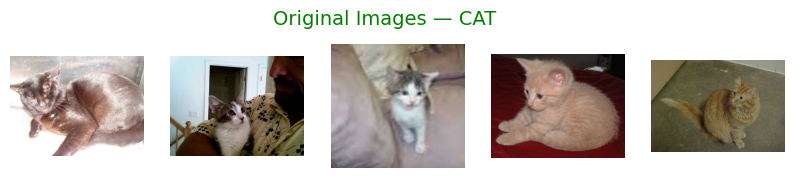

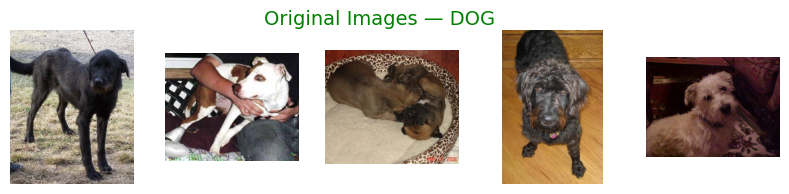

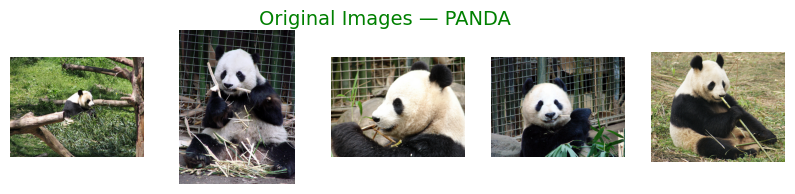

In [20]:
def preview_class_samples(label, n=5):
    folder = os.path.join(data, label)
    imgs = os.listdir(folder)[:n]
    plt.figure(figsize=(10,2))
    for i, fname in enumerate(imgs):
        path = os.path.join(folder, fname)
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Original Images — {label.upper()}", fontsize=14, color='green')
    plt.show()
for c in class_names:
    preview_class_samples(c)


**Convert Into Grayscale (32x32)**

In [21]:
image_size = 32
X = []
y = []
for label, cls in enumerate(class_names):
    class_path = os.path.join(data, cls)
    image_files = os.listdir(class_path)
    print(f"Class Selected: {cls}  -> label = {label}")
    for img_name in image_files:
        # Only process image formats
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        img_path = os.path.join(class_path, img_name)
        # Read image
        img = cv2.imread(img_path)
        if img is None:
            print("Skipping unreadable file:", img_path)
            continue
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Resize to 32x32
        gray_resized = cv2.resize(gray, (image_size, image_size))
        # Flatten to 1D vector (32*32 = 1024)
        flat = gray_resized.flatten()
        # Append to our dataset
        X.append(flat)
        y.append(label)
# Convert lists to numpy arrays
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)
print("X shape (samples, features):", X.shape)
print("y shape (labels):", y.shape)
print("First 20 labels:", y[:20])
# NORMALIZE PIXELS (0-1 range)
X = X / 255.0
print("Min pixel value:", X.min())
print("Max pixel value:", X.max())

Class Selected: cat  -> label = 0
Class Selected: dog  -> label = 1
Class Selected: panda  -> label = 2
X shape (samples, features): (300, 1024)
y shape (labels): (300,)
First 20 labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Min pixel value: 0.0
Max pixel value: 1.0


**Show Grayscale Images**

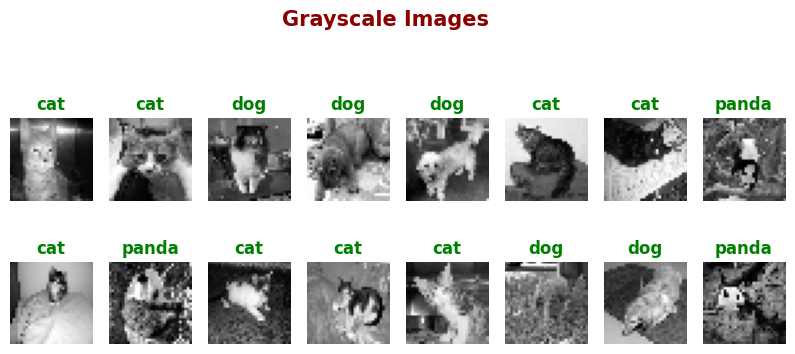

Dataset combined and shuffled.


In [22]:
num_preview = 16
random_indexes = random.sample(range(len(X)), num_preview)
plt.figure(figsize=(10, 9))
for i, idx in enumerate(random_indexes):
    img = X[idx].reshape(32, 32)
    plt.subplot(5, 8, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(class_names[y[idx]], fontsize=12, fontweight='bold', color='green')    # map label to class name
    plt.axis('off')
plt.suptitle("Grayscale Images", fontsize=15, fontweight='bold', color='darkred')
plt.show()
dataset_pairs = list(zip(X, y))
random.shuffle(dataset_pairs)
print("Dataset combined and shuffled.")

**Create 5 Folds DISTANCE FUNCTIONS**

In [23]:
num_folds = 5
fold_len = len(dataset_pairs) // num_folds  # 300/5 = 60
fold_list = [ dataset_pairs[i*fold_len : (i+1)*fold_len] for i in range(num_folds) ]
print("Fold sizes:")
for i, f in enumerate(fold_list):
    print(f" Fold {i}: {len(f)} samples")


def manhattan_distance(x, y):
    # Sum of absolute differences
    return np.sum(np.abs(x - y))

def euclidean_distance(x, y):
    # Square root of sum of squared differences
    return np.sqrt(np.sum((x - y) ** 2))

# Test distance between two different images
d_l1 = manhattan_distance(X[0], X[1])
d_l2 = euclidean_distance(X[0], X[1])

print(f"Test L1 distance between image 0 and 1: {d_l1:.2f}")
print(f"Test L2 distance between image 0 and 1: {d_l2:.2f}")

# Test distance between the same image (should be 0)
same_image_d1 = manhattan_distance(X[10], X[10])
same_image_d2 = euclidean_distance(X[20], X[20])

print(f"Test L1 distance of same feature/image: {same_image_d1:.2f}")
print(f"Test L2 distance of same feature/image: {same_image_d2:.2f}")


Fold sizes:
 Fold 0: 60 samples
 Fold 1: 60 samples
 Fold 2: 60 samples
 Fold 3: 60 samples
 Fold 4: 60 samples
Test L1 distance between image 0 and 1: 391.28
Test L2 distance between image 0 and 1: 15.04
Test L1 distance of same feature/image: 0.00
Test L2 distance of same feature/image: 0.00


**k-NN Classifier**

In [24]:
def knn_predict(X_train, y_train, x_test, k=5, distance_type='l2'):
    distances = []  # to store (distance, label)
    # Compute distance between test sample and all training samples
    for i in range(len(X_train)):
        if distance_type == 'l1':
            d = manhattan_distance(X_train[i], x_test)
        else:
            d = euclidean_distance(X_train[i], x_test)
        distances.append((d, y_train[i]))
    # Sort by distance (small → big)
    distances.sort(key=lambda x: x[0])
    # Take first k labels
    k_labels = [label for _, label in distances[:k]]
    # Count which label appears the most (majority voting)
    label_count = {}
    for label in k_labels:
        label_count[label] = label_count.get(label, 0) + 1
    # Return the label with the highest vote
    return max(label_count, key=label_count.get)

**5-Fold Cross Validation for k-NN**

In [25]:
def run_knn_cv(folds, k_values, distance_type='l2'):
    fold_accuracies = []
    for fold_idx in range(len(folds)):
        # 1. Select validation fold
        val_data = folds[fold_idx]
        # 2. Combine the other 4 folds into training data
        train_data = []
        for i in range(len(folds)):
            if i != fold_idx:
                train_data.extend(folds[i])
        # Separate features and labels
        X_train = np.array([item[0] for item in train_data])
        y_train = np.array([item[1] for item in train_data])
        X_val   = np.array([item[0] for item in val_data])
        y_val   = np.array([item[1] for item in val_data])
        # Store accuracies for this fold
        fold_acc = []
        for k in k_values:
            correct = 0
            for j in range(len(X_val)):
                pred = knn_predict(X_train, y_train, X_val[j], k=k, distance_type=distance_type)
                if pred == y_val[j]:
                    correct += 1
            accuracy = correct / len(X_val)
            fold_acc.append(accuracy)
        fold_accuracies.append(fold_acc)
        print(f"Fold {fold_idx} Done")
    # Average accuracy across 5 folds
    avg_accuracy = np.mean(fold_accuracies, axis=0)
    return fold_accuracies, avg_accuracy

**Run Cross-Validation for Multiple K Values (L1 and L2)**

In [26]:
K_values = np.arange(1, 13)
print("---  Manhattan (L1) ---")
fold_acc_l1, avg_acc_l1 = run_knn_cv(fold_list, K_values, distance_type='l1')
print("---  Euclidean (L2) ---")
fold_acc_l2, avg_acc_l2 = run_knn_cv(fold_list, K_values, distance_type='l2')

---  Manhattan (L1) ---
Fold 0 Done
Fold 1 Done
Fold 2 Done
Fold 3 Done
Fold 4 Done
---  Euclidean (L2) ---
Fold 0 Done
Fold 1 Done
Fold 2 Done
Fold 3 Done
Fold 4 Done


**PLOT RESULTS FOR EACH FOLD (L1 & L2)**

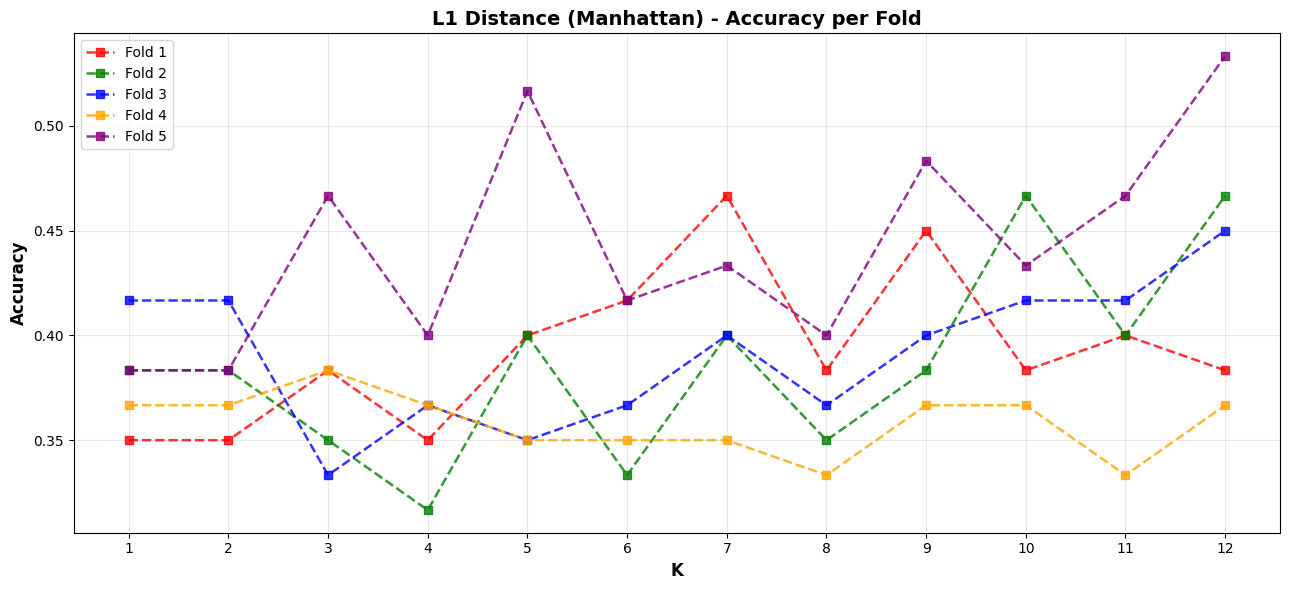

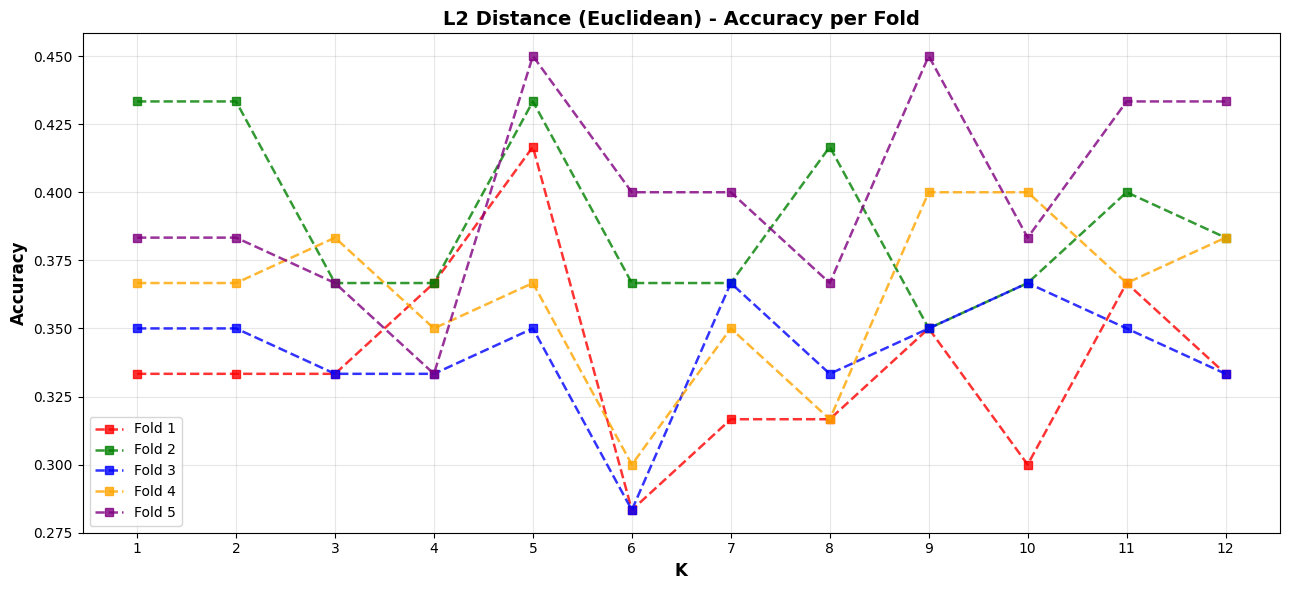

In [27]:
fold_colors = ['red', 'green', 'blue', 'orange', 'purple']
def plot_fold_accuracy(K_values, fold_accuracies, title):
    plt.figure(figsize=(13, 6))
    for i, acc in enumerate(fold_accuracies):
        plt.plot(K_values, acc, 's--', color=fold_colors[i % len(fold_colors)],
                 alpha=0.8, linewidth=1.8, markersize=6, label=f'Fold {i+1}')
    plt.xlabel('K', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks(K_values)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()
plot_fold_accuracy(K_values, fold_acc_l1, 'L1 Distance (Manhattan) - Accuracy per Fold')
plot_fold_accuracy(K_values, fold_acc_l2, 'L2 Distance (Euclidean) - Accuracy per Fold')


**PLOT AVERAGE ACCURACY FOR L1 vs L2 (MAIN GRAPH)**

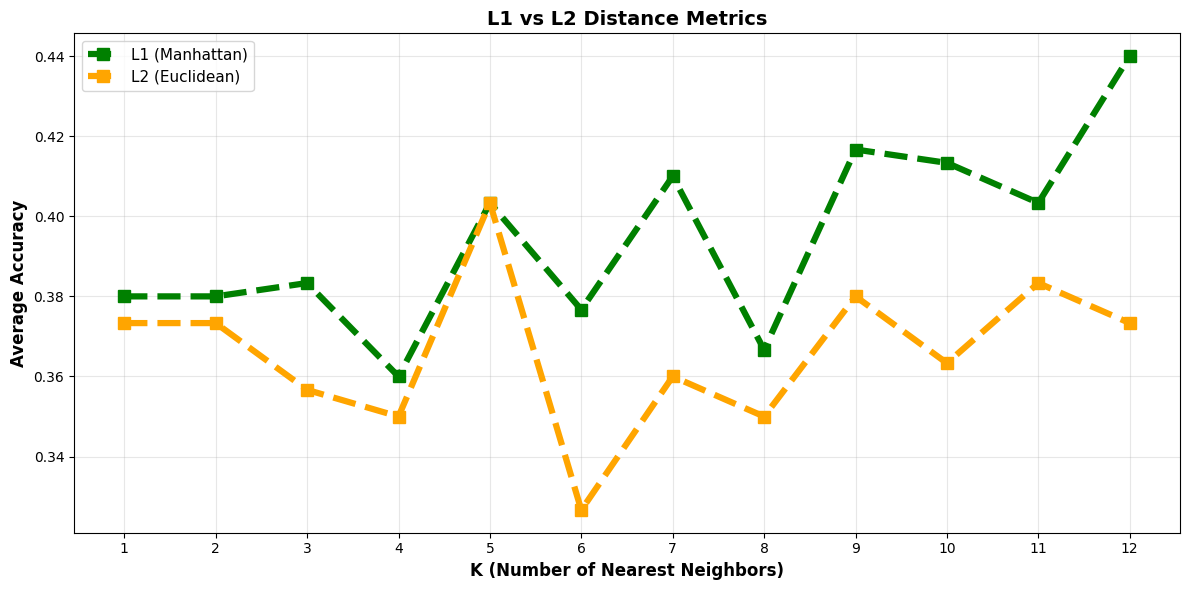

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(K_values, avg_acc_l1, 's--', color='green', linewidth=4.5,
         markersize=8, label='L1 (Manhattan)')
plt.plot(K_values, avg_acc_l2, 's--', color='orange', linewidth=4.5,
         markersize=8, label='L2 (Euclidean)')
plt.xlabel('K (Number of Nearest Neighbors)', fontsize=12, fontweight='bold')
plt.ylabel('Average Accuracy', fontsize=12, fontweight='bold')
plt.title('L1 vs L2 Distance Metrics',
          fontsize=14, fontweight='bold')
plt.xticks(K_values)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

**PRINT AVERAGE ACCURACY FOR EACH K (L1 and L2)**

In [29]:
# **PRINT AVERAGE ACCURACY FOR EACH K VALUE**
print("K   |   L1 Accuracy (%)   |   L2 Accuracy (%)")
print("---------------------------------------------")
for k, acc1, acc2 in zip(K_values, avg_acc_l1, avg_acc_l2):
    print(f"{k:2d}  |     {acc1*100:6.2f}%       |      {acc2*100:6.2f}%")

K   |   L1 Accuracy (%)   |   L2 Accuracy (%)
---------------------------------------------
 1  |      38.00%       |       37.33%
 2  |      38.00%       |       37.33%
 3  |      38.33%       |       35.67%
 4  |      36.00%       |       35.00%
 5  |      40.33%       |       40.33%
 6  |      37.67%       |       32.67%
 7  |      41.00%       |       36.00%
 8  |      36.67%       |       35.00%
 9  |      41.67%       |       38.00%
10  |      41.33%       |       36.33%
11  |      40.33%       |       38.33%
12  |      44.00%       |       37.33%


**FIND THE BEST K AND BEST METRIC (L1 or L2)**

In [30]:
best_k_l1 = K_values[np.argmax(avg_acc_l1)]
best_acc_l1 = max(avg_acc_l1)
best_k_l2 = K_values[np.argmax(avg_acc_l2)]
best_acc_l2 = max(avg_acc_l2)
print("\nBEST RESULTS:")
print(f"Manhattan (L1): Best K = {best_k_l1},  Accuracy = {best_acc_l1*100:.2f}%")
print(f"Euclidean (L2): Best K = {best_k_l2},  Accuracy = {best_acc_l2*100:.2f}%")
if best_acc_l1 > best_acc_l2:
    final_metric = 'l1'
    final_k = best_k_l1
else:
    final_metric = 'l2'
    final_k = best_k_l2
print(f"\nWINNER: Using {final_metric.upper()} distance with K = {final_k}")


BEST RESULTS:
Manhattan (L1): Best K = 12,  Accuracy = 44.00%
Euclidean (L2): Best K = 5,  Accuracy = 40.33%

WINNER: Using L1 distance with K = 12


**TOP 5 PREDICTIONS**


Using best configuration: Distance = L1, K = 12


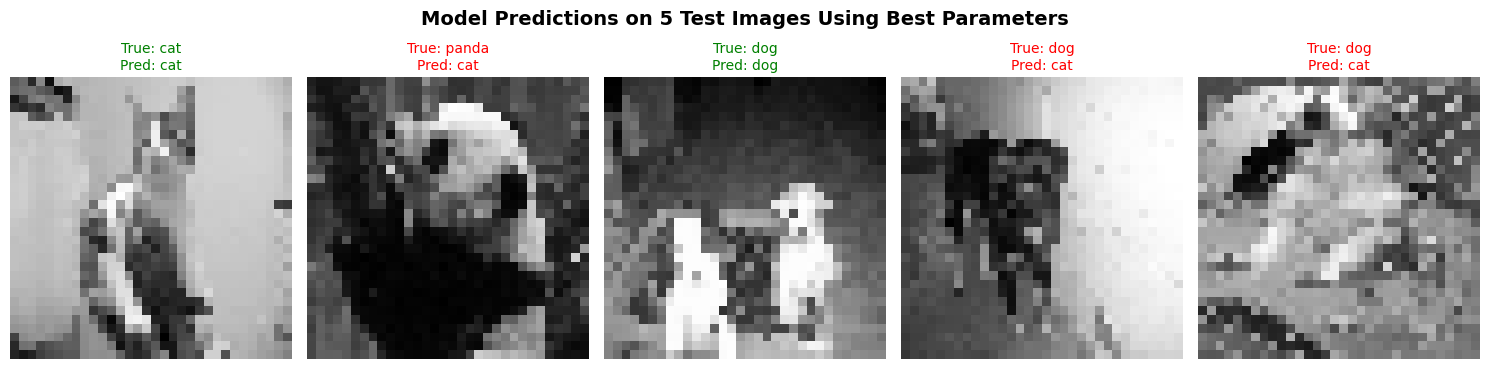

Correct Prediction: 2/5
Final Accuracy: 40.00%


In [31]:
best_metric = 'l2' if best_acc_l2 > best_acc_l1 else 'l1'
best_k = best_k_l2 if best_acc_l2 > best_acc_l1 else best_k_l1
print(f"\nUsing best configuration: Distance = {best_metric.upper()}, K = {best_k}")
test_data = fold_list[0]     # first fold = test set
train_data = []
for i in range(1, 5):         # remaining folds (1-4) = training set
    train_data.extend(fold_list[i])
X_train = np.array([item[0] for item in train_data])
y_train = np.array([item[1] for item in train_data])
num_show = 5      # Show 5 predictions
fig, axes = plt.subplots(1, num_show, figsize=(15, 4))
correct = 0
for i in range(num_show):
    x_test, y_true = test_data[i]
    y_pred = knn_predict(
        X_train, y_train,
        x_test,
        k=best_k,
        distance_type=best_metric
    )
    color = 'green' if y_pred == y_true else 'red'
    if y_pred == y_true:
        correct += 1
    axes[i].imshow(x_test.reshape(32, 32), cmap='gray')
    axes[i].set_title(
        f"True: {class_names[y_true]}\nPred: {class_names[y_pred]}",
        color=color,
        fontsize=10
    )
    axes[i].axis('off')
plt.suptitle(
    "Model Predictions on 5 Test Images Using Best Parameters",
    fontsize=14, fontweight='bold'
)
plt.tight_layout()
plt.show()
print(f"Correct Prediction: {correct}/{num_show}")
print(f"Final Accuracy: {(correct/num_show)*100:.2f}%")
